In [1]:
import numpy as np

# Load the data from the file
data = np.load('psths.npz')
X = data['X']     # 3D array with dimensions N x C x T
times = data['times']  # 1D array with time points

N, C, T = X.shape

In [2]:
### Control Analysis
t0 = 65
# Initialize an array with half 1's and half 0's per row

np.random.seed(10)


# 1 Different random condistion for different neurons
randomarray = np.zeros((N, C), dtype=int)
randomarray[:, :C//2] = 2  # Set the first half of each row to 1
randomarray -= 1
for row in randomarray:
    np.random.shuffle(row)

# 2 less extreame case: same random condistion for different neurons
# randomarray = np.zeros((N, C), dtype=int)
# randomarray[:, :C//2] = 2  # Set the first half of each row to 1
# randomarray -= 1
# randomarray = np.swapaxes(randomarray, 1, 0)
# np.random.shuffle(randomarray)
# randomarray = np.swapaxes(randomarray, 1, 0)

# randomarray += 1
# print(X[:,:,t0])
# X[:,:,t0:T] = X[:,:,t0] + (X[:,:,t0:T]-X[:,:,t0]) * randomarray
X[:,:,t0:T] = X[:,:,t0][:,:,np.newaxis] + (X[:,:,t0:T] - X[:,:,t0][:,:,np.newaxis]) * randomarray[:,:,np.newaxis]


# 3. Reshuffle Time bins
# X = np.swapaxes(X, 2, 0)
# np.random.shuffle(X)
# X = np.swapaxes(X, 2, 0)

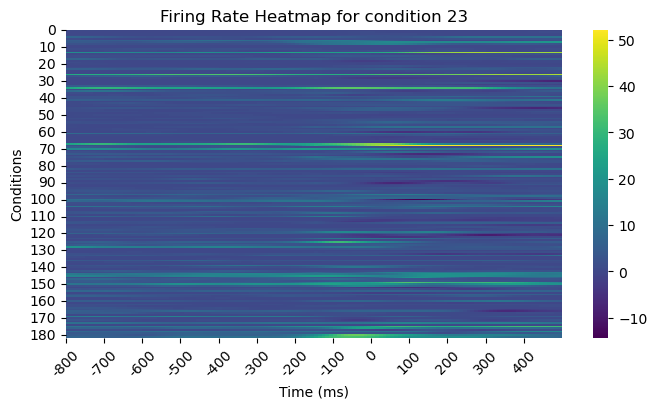

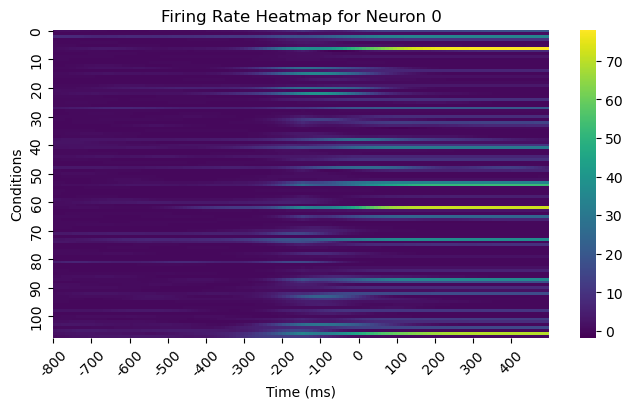

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a condition (e.g., condition 0)
condition = 23
firing_rate = X[:, condition, :] # Shape N x T

plt.figure(figsize=(8, 4))
sns.heatmap(firing_rate, xticklabels=10, yticklabels=10, cmap='viridis')

# Set the X-axis ticks with specific time points for better clarity
plt.xticks(ticks=range(0, len(times), 10), labels=times[::10], rotation=45)
plt.xlabel("Time (ms)")
plt.ylabel("Conditions")
plt.title(f"Firing Rate Heatmap for condition {condition}")
plt.show()
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a neuron (e.g., neuron 0)
neuron = 0
neuron_data = X[neuron, :, :]  # Shape C x T

plt.figure(figsize=(8, 4))
sns.heatmap(neuron_data, xticklabels=10, yticklabels=10, cmap='viridis')

# Set the X-axis ticks with specific time points for better clarity
plt.xticks(ticks=range(0, len(times), 10), labels=times[::10], rotation=45)
plt.xlabel("Time (ms)")
plt.ylabel("Conditions")
plt.title(f"Firing Rate Heatmap for Neuron {neuron}")
plt.show()

### 1. Plot raw PSTHs

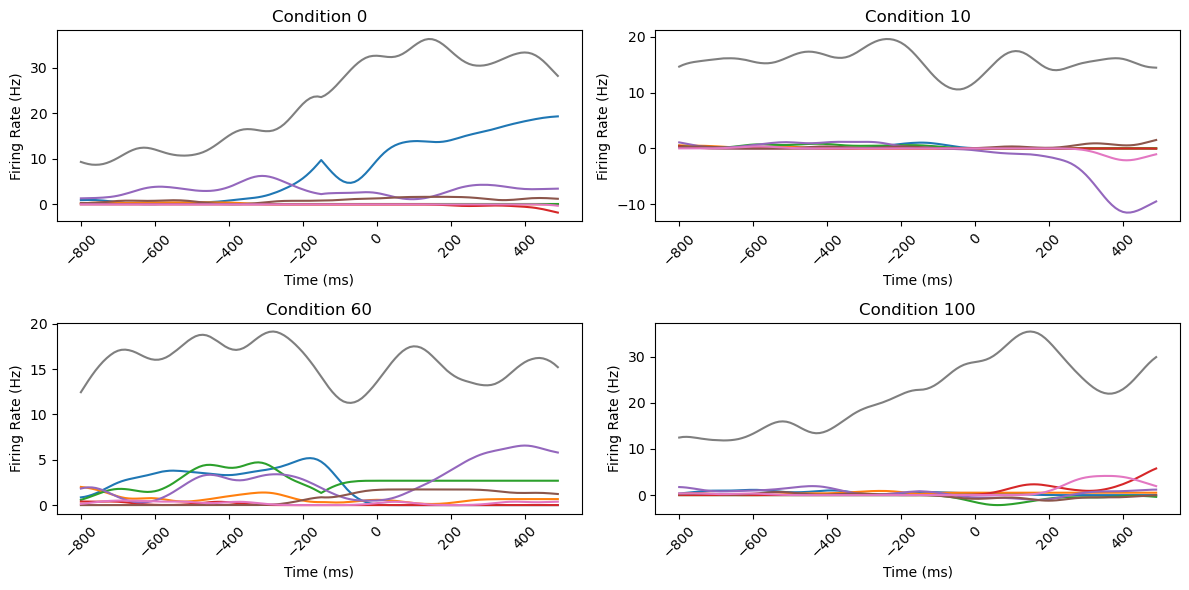

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sample_neurons = [0, 10, 20, 30, 40, 50, 80, 150]  # Indices of representative neurons
sample_conditions = [0, 10, 60, 100]     # Indices of a few conditions

# Plotting PSTHs for the selected neurons and conditions
plt.figure(figsize=(12, 6))


for j, condition in enumerate(sample_conditions):
    plt.subplot(2, 2, j + 1)
    for i, neuron in enumerate(sample_neurons):
        plt.plot(times, X[neuron, condition, :])

    plt.xlabel("Time (ms)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title(f"Condition {condition}")
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

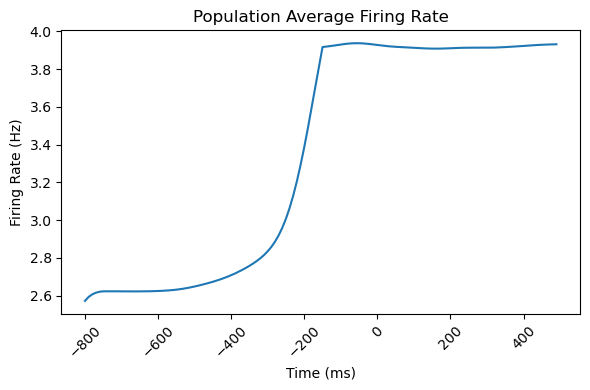

In [5]:
# Plotting PSTHs for the selected neurons and conditions
plt.figure(figsize=(6, 4))

plt.plot(times, X.mean(axis=(0,1)))

plt.xlabel("Time (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.title(f"Population Average Firing Rate")
plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

### Preprocessing

(a,b) Normalization and Mean centering

In [6]:
max_firingrate = X.max(axis=(1,2), keepdims=True) # shape: N=182
min_firingrate = X.min(axis=(1,2), keepdims=True) # shape: N=182
normalized_X = (X - min_firingrate) / (max_firingrate - min_firingrate + 5)
separate_mean = normalized_X.mean(axis=1, keepdims=True)
mean_centered_X = normalized_X - separate_mean


print(max_firingrate.shape)
print(normalized_X.shape)
print(mean_centered_X.shape)

(182, 1, 1)
(182, 108, 130)
(182, 108, 130)


In [7]:
X_clean = mean_centered_X

(c) PCA

In [8]:
start_time_idx = 65
end_time_idx = 111
T = end_time_idx-start_time_idx
print(times[start_time_idx:end_time_idx])
times_short = times[start_time_idx:end_time_idx]
X_short = X_clean[:, :, start_time_idx:end_time_idx]
print(X_short.shape)

[-150 -140 -130 -120 -110 -100  -90  -80  -70  -60  -50  -40  -30  -20
  -10    0   10   20   30   40   50   60   70   80   90  100  110  120
  130  140  150  160  170  180  190  200  210  220  230  240  250  260
  270  280  290  300]
(182, 108, 46)


In [9]:
X_reshaped = X_short.reshape(X_short.shape[0], -1)
print(f'reshaped X_short: {X_reshaped.shape}')

reshaped X_short: (182, 4968)


cov_matrix: (182, 182)
V_M: (182, 12)
Z: (12, 4968)


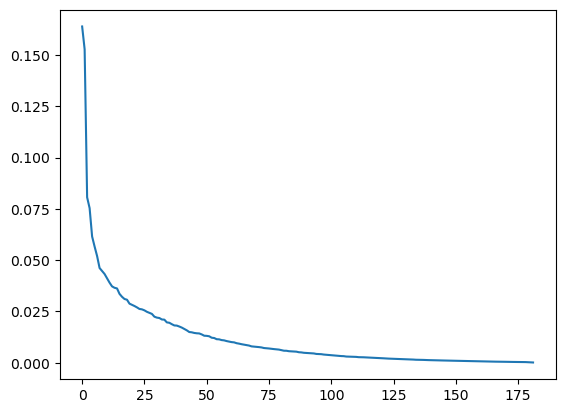

In [10]:
M = 12

cov_matrix = np.cov(X_reshaped)
print(f'cov_matrix: {cov_matrix.shape}')

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

plt.figure()
plt.plot(eigenvalues)
V_M = eigenvectors[:, :M]  # Top M eigenvectors
print(f'V_M: {V_M.shape}')

Z = V_M.T @ X_reshaped
print(f'Z: {Z.shape}')

### Plotting PC space trajectories

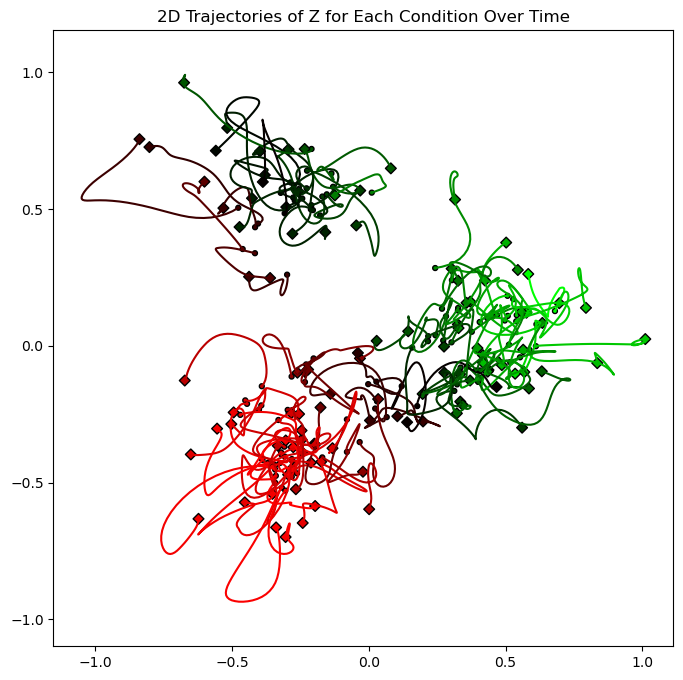

In [11]:
from cond_color import *

# data = np.load('test.npz')
# Z_test = data['Z_test']    # M,C,(T-1)
# A_test = data['A_test']     # M,M
# Z_3d = Z_test # (M=2, C, T)
Z_3d = Z.reshape(Z.shape[0],C,-1) # (M=2, C, T)
plot_Z_projection(Z_3d, title='2D Trajectories of Z for Each Condition Over Time')

### 4. Finding the maximum-likelihood esitimate for A

Build \Delta Z

In [12]:
dZ_3d = np.diff(Z_3d, axis=2)
print('dZ_3d:',dZ_3d.shape)
Z_3d_short = Z_3d[:,:,:-1]
print('Z_3d_short:',Z_3d_short.shape)

Z_short = Z_3d_short.reshape(dZ_3d.shape[0],-1)
print('Z_short:',Z_short.shape)
dZ = dZ_3d.reshape(dZ_3d.shape[0],-1)
print('dZ:',dZ.shape)


dZ_3d: (12, 108, 45)
Z_3d_short: (12, 108, 45)
Z_short: (12, 4860)
dZ: (12, 4860)


In [13]:
# M=4 # test case
# beta = np.linspace(1,K,K)

K = int(M*(M-1)/2)
print('K:',K)

H = np.zeros((K, M, M), dtype=int)
k = 0
for i in range(M):
    for j in range(M):
        if j > i:
            H[k, i, j] = 1
            H[k, j, i] = -1
            k+=1
print('number of 1 = ', k)

def compute_A(H, beta):
    """
    Parameters:
        beta (np.ndarray): A 1D array of shape [K].
        H (np.ndarray): A 3D array of shape [K, M, M].

    Returns:
        A (np.ndarray): A 2D array of shape [M, M].

    Raises:
        ValueError: If the shapes of beta and H are incompatible.
    """
    # Check dimensions
    if len(beta.shape) != 1:
        raise ValueError(f"Invalid shape for beta. Expected 1D array of shape [K], but got {beta.shape}.")

    if len(H.shape) != 3:
        raise ValueError(f"Invalid shape for H. Expected 3D array of shape [K, M, M], but got {H.shape}.")

    if beta.shape[0] != K:
        raise ValueError(f"Incompatible shapes for beta and H. Got beta: {beta.shape}, H: {H.shape}.")

    if H.shape[0] != K or H.shape[1] != M or H.shape[2] != M:
        raise ValueError(f"Incompatible shapes for beta and H. Got beta: {beta.shape}, H: {H.shape}.")
    
    # Compute A
    A = np.sum(H * beta[:, None, None], axis=0)
    return A

def compute_W(H, Z):
    """
    Computes W = H @ Z with shape checks.
    
    Parameters:
        H (np.ndarray): A 3D array of shape [K, M, M].
        Z (np.ndarray): A 2D array of shape [M, C(T-1)].
    
    Returns:
        W (np.ndarray): A 3D array of shape [K, M, C(T-1)].
    
    Raises:
        ValueError: If the shapes of H and Z_short are incompatible.
    """
    # Check input shapes
    if len(H.shape) != 3 or len(Z.shape) != 2:
        raise ValueError(f"Invalid shapes: H must be [K, M, M] and Z_short must be [M, C(T-1)]. Got H: {H.shape}, Z_short: {Z_short.shape}.")
        
    if H.shape[0] != K or H.shape[1] != M or H.shape[2] != M:
        raise ValueError(f"Incompatible shapes for matrix multiplication. Got H: {H.shape}.")

    if Z.shape[0] != M or Z.shape[1] != C*(T-1):
        raise ValueError(f"Incompatible shapes for matrix multiplication. Got Z: {Z.shape}.")
    
    # Perform the multiplication
    W = np.einsum('kmn,nc->kmc', H, Z)

    # Verify the output shape
    expected_shape = (K, M, C*(T-1))
    if W.shape != expected_shape:
        raise ValueError(f"Unexpected output shape. Expected {expected_shape}, but got {W.shape}.")
    
    return W


import numpy as np

def compute_beta(W, dZ):
    """
    Computes beta using the formula β = (WWT)^(-1)W∆Z.
    
    Parameters:
        W (np.ndarray): A 2D array of shape [K, M, C*(T-1)].
        dZ (np.ndarray): A 2D array of shape [M, C*(T-1)].
    
    Returns:
        beta (np.ndarray): A 1D array of shape [K].

    Raises:
        ValueError: If the input dimensions are incompatible.
    """
    # Input dimension checks
    if len(H.shape) != 3 or len(Z.shape) != 2 or len(dZ.shape) != 2:
        raise ValueError("Invalid input shapes. H must be [K, M, M], Z and delta_Z must be [M, C*(T-1)].")
    
    if W.shape[0] != K or W.shape[1] != M or W.shape[2] != C*(T-1):
        raise ValueError(f"Incompatible shapes for matrix multiplication. Got H: {H.shape}.")
    
    if dZ.shape[0] != M or dZ.shape[1] != C*(T-1):
        raise ValueError(f"Incompatible shapes for matrix multiplication. Got Z: {Z.shape}.")

    # Reshape W to [K, M*C*(T-1)]
    W_flat = W.reshape(K, -1)  # Flatten along the last two dimensions

    # Reshape delta_Z to [M*C*(T-1)]
    delta_Z_flat = dZ.flatten()  # Flatten delta_Z to a 1D vector

    # Compute β = (W W⊤)^(-1) W ∆Z
    WW_t = np.dot(W_flat, W_flat.T)  # W W⊤, shape [K, K]
    WW_t_inv = np.linalg.inv(WW_t)  # Inverse of W W⊤, shape [K, K]
    beta = np.dot(WW_t_inv, np.dot(W_flat, delta_Z_flat))  # Compute β, shape [K]

    return beta


def estimate_A(Z):
    M = Z.shape[0]
    C = 108
    CT_minus_1 = Z.shape[1]
    print('T=',Z.shape[1]/C)
    
    K = int(M*(M-1)/2)

    H = np.zeros((K, M, M), dtype=int)
    k = 0
    for i in range(M):
        for j in range(M):
            if j > i:
                H[k, i, j] = 1
                H[k, j, i] = -1
                k+=1

    Z_3d = Z.reshape(Z.shape[0],C,-1) # (M=2, C, T)
    dZ_3d = np.diff(Z_3d, axis=2)
    Z_3d_short = Z_3d[:,:,:-1]

    Z_short = Z_3d_short.reshape(dZ_3d.shape[0],-1)
    dZ = dZ_3d.reshape(dZ_3d.shape[0],-1)

    W = compute_W(H, Z_short)  # Shape will be [K, M, C(T-1)]
    beta_estim = compute_beta(W, dZ)
    A = compute_A(H,beta_estim)

    return A

K: 66
number of 1 =  66


Compute W, Estimate beta and A

In [14]:
# Assuming H.shape = [K, M, M] and Z_3d_short.shape = [M, C(T-1)]
print('H:', H.shape)
print('Z_short:', Z_short.shape)

# Compute W
W = compute_W(H, Z_short)  # Shape will be [K, M, C(T-1)]
beta_estim = compute_beta(W, dZ)
A_hat = compute_A(H,beta_estim)


H: (66, 12, 12)
Z_short: (12, 4860)


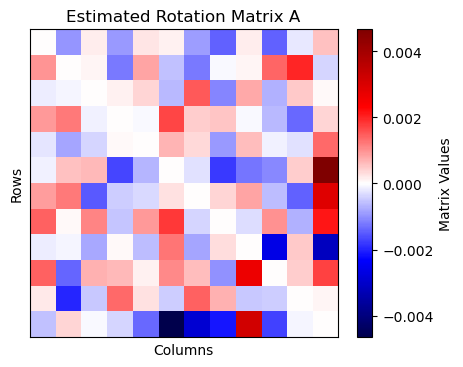

In [15]:
plt.figure(figsize=(5, 4))
plt.imshow(A_hat, cmap='seismic', interpolation='nearest')
plt.colorbar(label="Matrix Values")
plt.title('Estimated Rotation Matrix A')
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.grid(False)
plt.xticks([])
plt.yticks([])
# # Add annotations
# for (i, j), val in np.ndenumerate(A_estiim):
#     plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color="black")

plt.show()

### 2D Projections with rotational dynamics

In [16]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A_hat)

np.set_printoptions(precision=3, suppress=True)  # Set precision for NumPy array printing

eigenvalues_imag_parts = np.imag(eigenvalues)
print("Imaginary parts of eigenvalues (angular velocities):")
print(eigenvalues_imag_parts[::2])



Imaginary parts of eigenvalues (angular velocities):
[0.008 0.004 0.004 0.002 0.001 0.   ]


Projection onto planes

Verify orthogonal:  2.2551405187698492e-17


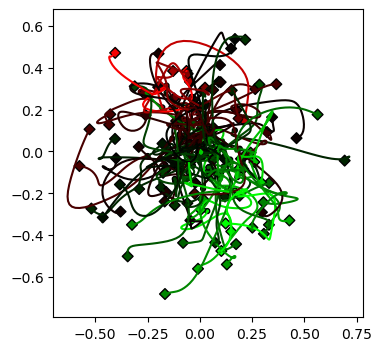

In [17]:
plane = 0
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

Pfr = compute_Pfr(eigenvalues,eigenvectors,plane)
# movement
Z_fr = Pfr@Z_short
Z_fr_3dvis = Z_fr.reshape(2, C, -1)[:,:,:-9] # -150,200ms
plot_Z_projection(Z_fr_3dvis, ax=axes, title=None)

# fig.suptitle("Projection of Z on FR planes", fontsize=16)
plt.show()

### Pre-movement period

### Control analysis